# Agent based modelling of social systems

### Modelling social awereness through a cognitive architecture model
Questions/Topics : 
* What is our question(clear formulation)-> Global awereness
* Topology of network
* Network generator (random?)
* Interaction of agents
* Literature
* Assumptions

### Structure
* Output: Plot Magnitude of event vs Importance of agent (color:fraction of agents, prob. to pass threshold)
* Model: 
 * P(k) distribution of #of outward lines
 * Interaction as a weighted relation of importance of agent and magnitude of event)
* Network: 
 * Random neighbour selection
 * % of neighbours interaction in each time step
* Events
 * Prob. distribution of events log(magn)= $\beta$ - $\gamma$log(occurences)
 * Decay as an exponential function
 * Global magnitude state of each event

In [9]:
import numpy as np
import igraph
import matplotlib.pyplot as plt
from IPython.display import *
% matplotlib inline

def displayNetwork(g, visual_style={}):
    visual_style["vertex_size"]=g.vs["size"]
    visual_style["edge_arrow_size"] = 0.5
    visual_style["vertex_color"] = g.vs["color"]
    igraph.plot(g, "img/temp.png", **visual_style)
    display(Image(filename='img/temp.png'))
    
def displayPlot(plt):
    plt.savefig("img/temp_plot.png")
    display(Image(filename='img/temp_plot.png'))   

Network g contains 10 nodes
The vertex objects are:
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 0, {'size': 8, 'color': 'red'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 1, {'size': 15, 'color': 'cyan'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 2, {'size': 15, 'color': 'red'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 3, {'size': 8, 'color': 'cyan'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 4, {'size': 8, 'color': 'cyan'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 5, {'size': 15, 'color': 'red'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 6, {'size': 15, 'color': 'red'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 7, {'size': 15, 'color': 'red'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 8, {'size': 15, 'color': 'cyan'})
igraph.Vertex(<igraph.Graph object at 0x06B044B0>, 9, {'size': 15, 'color': 'blue'})


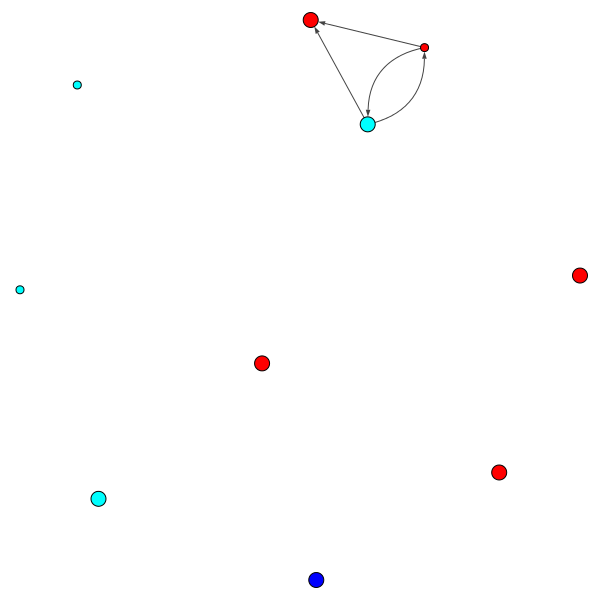

In [10]:
N=10

# number of peripheral and core agents
N1,N2=int(0.8*N),int(0.2*N)

# just to be sure that N is actually the sum of the two populations
N=int(0.8*N)+int(0.2*N)

# distribution probability for those agents
p1,p2=0.2,0.8



# g is the graph, with N vertices and directed edges
g=igraph.Graph(N,directed=True)

# We can add edges here, as a list of tuples
g.add_edges([(0,1),(1,0),(1,2),(0,2)])

# or add 30 random ones like this:
#for i in range(30):
 #   newlink=np.random.choice(N,2)
#  g.add_edge(newlink[0],newlink[1])

# let's remove double links and self-loops:
g=g.simplify()
# displys network


# g.vs is the vertex sequence of the graph g
print("Network g contains", len(g.vs), "nodes")
print("The vertex objects are:")
colors = ["red", "cyan"]
sizes = [8, 15]
for x in g.vs:
    x["color"] = np.random.choice(colors, 1)[-1]
    x["size"] = np.random.choice(sizes, 1)[-1]
    print(x)
displayNetwork(g)

In [36]:
class SocialNet:
    def __init__(self, N):
        self.N = N        
        self.g = igraph.Graph(self.N ,directed=True)
        self._create_agents() 
        self.visual_style = {}
        self.visual_style["vertex_size"]=self.g.vs["size"]
        self.visual_style["edge_arrow_size"] = 0.5 
    
    
    def _create_agents(self):
        for v in self.g.vs:
            links = self.scale_free_distr()
            v["size"] = 5 + 2*links
            v["links"] = links
        return
    
    def scale_free_distr(self):
        p = np.random.rand()
        if p <= 0.001:
            return 1
        else:
            return int(np.round(1/np.sqrt(p)))
        
    def update(self):
        pass
    
    def draw(self):        
        igraph.plot(self.g, "img/temp.png", **self.visual_style)
        display(Image(filename='img/temp.png')) 
        
    def displayPlot(self):
        plt.savefig("img/temp_plot.png")
        display(Image(filename='img/temp_plot.png'))

class Agent(igraph.Vertex):
    def __init__(self, name, num_links):
        self.attr = self.attributes()
        self.num_links = num_links
        self.visual_style["vertex_size"]=2*self.num_links
        self.visual_style["edge_arrow_size"] = 0.5
    def _create_links(self):
        pass
    def set_attributes(self):
        self.attr["size"] = int(self.num_links*2)        
        
        

            

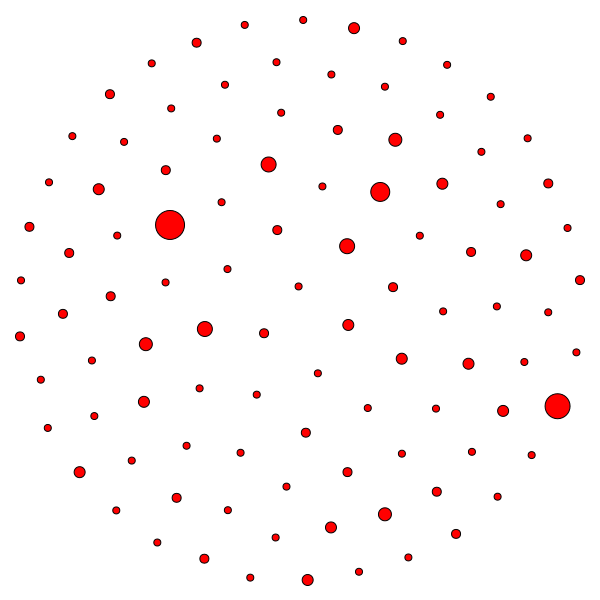

In [37]:
Net = SocialNet(100)
Net.draw()

In [38]:
max(Net.g.vs["links"])

12